# Mathematical Modeling and Numerical Simulation of Absorption and Desorption of Hydrogen in Long Metal Hydride Tank Equipped with Phase Change Material Jacket 

## Darzi e.a. - Journal Hydrogen Energy 2016 

## Import Julia Packages 

In [2]:
using LinearAlgebra
using DifferentialEquations
using StaticArrays
using Plots

In [10]:
# deliberately use include to include code 
# see e.g. https://docAs.julialang.org/en/v1/manual/code-loading/ 
include("flemish-fish.jl")

## Section 1: Introduction 

The <b>goals</b> of this notebook are:  
1. to reproduce the results by Darzi e.a. in their 2016 paper entitled <i>Absorption and Desorption of Hydrogen in Long Metal Hydride Tank Equipped with Phase Change Material Jacket</i>. This paper discusses the mathematical modeling and numerical simulation of metal-hydride materials for the storage (absorption (intake) and desorption (release)) of hygrogen gas. The [Van 't Hoff plot](https://en.wikipedia.org/wiki/Van_'t_Hoff_equation) is used to estimate the enthalpy (heat intake or release) and entropy of the chemical reaction of binding and release of hydrogen gas; 

1. <b>0D transient modeling</b>: to construct a zero-dimensional (perfectly stirred reactor) transient model for the storage (scenario-1) and release (scenario-2) of hydrogen gas from tank with and without MOFs. These models tracks the coupled time-evolution of two species. The first is the density of hydrogen gas density injected into the reactor. The second is the solid density (here intended as the amount of hydrogen gas absorbed by the MOF in the tank). The model is driven by a mass-flow rate. This mass-flow rate is linearly proportional to the solid density. Time stepping methods available in DifferentialEquations.jl will be used to solve these models.

1. <b>1D steady-state modeling</b>: to construct a one-dimensional stationary models for the storage (scenario-1) and release (scenario-2) of hydrogen gas from tank with (and without) MOFs. The model will consists of two submodels. The first submodel is a model for laminar non-isothermal flow of the hydrogen gas through the bed of metal-oxide material bed. This material bed will be modeled as a porous medium. This first submodel will consist of conservation of mass (diffusion equation for the pressure resulting in a pressure gradient over the reactor), conservation of momentum (convection-diffusion equation for the velocity) and conservation of energy. The second submodel is a model for the spatial and temporal variation of the hydrogen gas density and solid density. These models can be solved using shooting method available in DifferentialEquations.jl, finite difference methods implemented in FlemishFish.jl and finite element implemented in Ferrite.jl.

1. <b>1D transient modeling</b>: Extend previous models to transient case.

1. <b>2D transient modeling</b>: Extend previous models to two spatial dimensions.

1. collect information allowing an informed and critical discussion on future outlook with project partners;   

<img src="./darzi-2016-table1.png" width=800 />
Table-1 from Darzi-2016. 

More on the introduction will come later. 

<b>Next steps</b> Assume given 
1. 2D geometry consisting in inlets and walls only. Such a 2D geometry can be obtained by e.g. mirroring the wedge geometry wrt. the central axis;
2. isothermal flow conditions (in this case flow and adsorption decouple and can thus be solved seperately. Assume first Stokes and subsequently Navier-Stokes). Use post-processing functionality to recover velocity when solving for the species; 
4. velocity profile on the inlet (pressure inlet conditions will be treated later);

simulate absorption and desorption of h2-gas. 

## Section 2: 0D Transient Reactor Models 

### Section 2.1: Only Solid Density in Spatially Homogenous Reactor 

<b>Assumptions</b>: 
1. the reactor to be spatially homogeneous (well stirred reactor model, reactor has no spatial dimensions); 
1. pressure and temperature of reactor are constant; 
1. given empty bed density $\rho_{emp}$: see Table-1 for realistic value;  
1. saturated bed density $\rho_{sat}$: see Table-1 for realistic value?; 

<b>Problem Formulation</b>:

Model time-evolution of density of hydrogen gas bounded to the metal-oxide solid $\rho_s = \rho_s(t)$ in both absorption and desorption conditions, i.e, solve the (single) ordinary differential equation  

$$
(1 - \epsilon) \frac{d \, \rho_s}{dt} = \dot{m}(\rho_s, t) 
\text{ given } \rho_s(t = 0) = \rho_{s,0} \,    
$$

where for <b>absorption</b> conditions (density of solid increases until reaching saturation)

$$
\dot{m}(\rho_s, t) = \dot{m}_a(\rho_s, t)
                   = C_a \exp(- \frac{E_a}{R \, T}) \, 
                        \log( \frac{p_p}{p_{eq,a}} ) \, (\rho_{sat} - \rho_s(t)) \, ,     
$$

and for <b>desorption</b> conditions (density decreases until reaching minimum value)

$$
\dot{m}(\rho_s, t) = \dot{m}_d(\rho_s, t)
                   = C_d \exp(- \frac{E_d}{R \, T}) \, 
                         ( \frac{p_p - p_{eq,d}}{p_{eq,d}} ) \, 
                         (\rho_s(t) - \rho_{emp}) \, ,       
$$

assuming final time to evolve between one and a few minutes. Observe that 
1. the mass flow rate $\dot{m}(\rho_s, t)$ is <i>independent</i> of the density of the unbound hydrogen gas $\rho_g(t)$. This implies that $\dot{m}(\rho_s, t)$ has <b>no</b> spatial variation is case that $\rho_s$ has no spatial variation. The density $\rho_s$ has no spatial variation in that the initial conditions for $\rho_s$ has no spatial variations;  
1. the steady-state solution for absoroption and desorption is given by $\rho_s=\rho_{sat}$ and $\rho_s=\rho_{emp}$, respectively; 

<b>Coding</b>: see below; 

<b>Scenario-1: Absorption Case</b> 
Here we model an absorption case. This case is seperable and can thus be solved analytically using seperation of variables, either using pen-and-paper and symbolic computations (using sympy e.g.). 

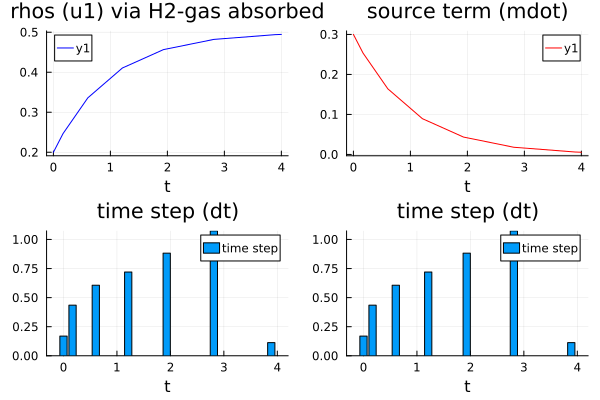

In [20]:
# problem set-up: rhs function that defines the ODE
function rhs(u,p,t)
    return (.5-u) # absorption assuming \rho_{sat} = 1 and multiplying factors equal 1
end 

# problem set-up: initial condition
uinit = .2;

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem 
prob = ODEProblem(rhs,uinit,tspan)

# solve: perform time integration 
sol = solve(prob,AutoVern7(Rodas5()),reltol=1e-4,abstol=1e-4)

# post-process: plot computed solution 
p1 = plot(sol.t, sol.u, xlabel = "t",line = :blue, title="rhos (u1) via H2-gas absorbed")

# post-process:evaluate and plot the source term 
p2 = plot(sol.t, rhs.(sol.u,1,sol.t),xlabel="t", line = :red, title="source term (mdot)")

# plot time step 
dt = sol.t[2:end] - sol.t[1:end-1]
p3 = bar(sol.t[1:end-1], dt, xlabel="t", label="time step", title="time step (dt)")

plot(p1,p2,p3,p3,layout=(2,2))

<b>Scenario-2: Desorption Case</b> 
Here we model an desorption case.

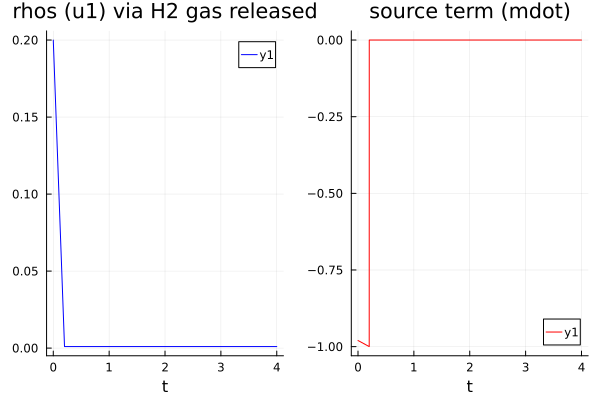

In [22]:
# problem set-up: rhs function that defines the ODE 
function rhs(u,p,t)
    return (0.1*u-1)*(u>0.001) # desorption assuming \rho_{emp} = 0.1 and rest equals 1 
end 

# problem set-up: initial condition 
uinit = .2;

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem 
prob = ODEProblem(rhs,uinit,tspan)

# solve: perform time integration 
sol = solve(prob,AutoVern7(Rodas5()),reltol=1e-4,abstol=1e-4)

# post-process: plot computed solution 
p1 = plot(sol.t, sol.u, xlabel = "t",line = :blue, title="rhos (u1) via H2 gas released")

# post-process:evaluate and plot the source term 
p2 = plot(sol.t, rhs.(sol.u,1,sol.t),xlabel="t", line = :red, title="source term (mdot)")
plot(p1,p2,layout=(1,2))

<b>In-place vs. Out-of-place definition of the RHS function</b>
1. requires further study 
1. what happens in case of setting autodiff to off?  

In [31]:
# problem set-up: rhs function that defines the ODE
function rhs!(du,u,p,t)
    du .= (.5-u) # absorption assuming \rho_{sat} = 1 and multiplying factors equal 1
end 

# problem set-up: initial condition
uinit = .2;

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem 
# prob = ODEProblem(rhs!,uinit,tspan)

#oderhs! = ODEFunction(rhs!; jac = my_jac!)
oderhs! = ODEFunction(rhs!)
prob = ODEProblem(oderhs!, uinit, tspan, p);

# solve: perform time integration 
sol = solve(prob,AutoVern7(Rodas5(autodiff = false)),reltol=1e-4,abstol=1e-4)

LoadError: Initial condition incompatible with functional form.
Detected an in-place function with an initial condition of type Number or SArray.
This is incompatible because Numbers cannot be mutated, i.e.
`x = 2.0; y = 2.0; x .= y` will error.

If using a immutable initial condition type, please use the out-of-place form.
I.e. define the function `du=f(u,p,t)` instead of attempting to "mutate" the immutable `du`.

If your differential equation function was defined with multiple dispatches and one is
in-place, then the automatic detection will choose in-place. In this case, override the
choice in the problem constructor, i.e. `ODEProblem{false}(f,u0,tspan,p,kwargs...)`.

For a longer discussion on mutability vs immutability and in-place vs out-of-place, see:
https://diffeq.sciml.ai/stable/tutorials/faster_ode_example/#Example-Accelerating-a-Non-Stiff-Equation:-The-Lorenz-Equation


Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


### Section 2.2: Coupled Solid/Gas Density in Spatially Homogenous Reactor

<b>Assumptions</b>: as before 

<b>Problem Formulation</b>:

Model time-evolution of hydrogen gas bounded to the metal-oxide solid $\rho_s = \rho_s(t)$ and density of the hydrogen gas $\rho_g = \rho_g(t)$  in both absorption and desorption conditions, i.e, solve the two ordinary differential equations coupled via the depency of the flow rate on the 

$$
(1 - \epsilon) \frac{d \, \rho_s}{dt} = \dot{m}(\rho_s, t) 
\text{ given } \rho_s(t = 0) = \rho_{s,0} \,    
$$

and 

$$
\epsilon \frac{d \, \rho_g}{dt} = - \dot{m}(\rho_s, t) 
\text{ given } \rho_g(t = 0) = \rho_{g,0} \, .     
$$

Not sure about signs in the equation. 

<b>Remarks</b>: what initial conditions make sense to use here? 

<b>Coding</b>: extend before from one to two coupled ordinary differential equations. 

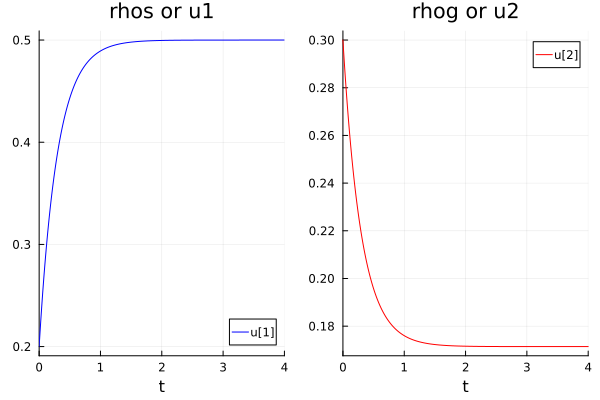

In [7]:
# Scenario-1: absorption case: du > 0 : density of solid (amount of gas absorbed) increases until reaching saturation
# problem set-up: rhs function that defines the ODE 
function rhs!(du,u,p,t)
 mdot = (.5-u[1])
 epsilon = 0.7 
 du[1] = mdot/(1-epsilon)
 du[2] = -mdot/epsilon 
end

# problem set-up: initial condition
u0 = [0.2,0.3] 

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem
prob = ODEProblem(rhs!,u0,tspan)

# solve: perform time integration
sol = solve(prob)

# post-process: plot computed solution
p1 = plot(sol,idxs=1,line = :blue,title="rhos or u1")
p2 = plot(sol,idxs=2,line = :red,title="rhog or u2")
plot(p1,p2,layout = (1,2))

### Section 2.3: Pressure Evolution During Tank Fill / Emptying 

See [zero-D-reactor-model](zero-D-reactor-model.ipynb). 

### Section 2.4: Exercises 

1. compare explicit and implicit time integration methods in terms of CPU time and memory using @btime from [BenchmarkTools.jl](https://github.com/JuliaCI/BenchmarkTools.jl);
2. compare fixed (using the keyword dt = ) and variable time step;
3. compare no Jacobian, hand-coded Jacobian and automatic differentiation for the Jacobian; 

## Section 3: One-Dimensional Reactor Models With A-Priori Given Axial Velocity 

<b>Assumptions</b>:
1. assume reactor to extend in space along the $z$-axis of a cylindrical coordinate system from $z=0$ to $z = 0.8 \, \text{m}$. 
2. assume $z$-axis to be discretized using either an uniform mesh or non-uniform mesh; 
3. for both the absorption and desorption case, assume the axial velocity $u_z(z)$ (in $\text{m}/\text{s}$) to be a given function of $z$. Examples include linear profiles for $u_z(z)$ (in positive $z$-direction for absorption and in negative $z$-direction for desorption) or solutions of the convection-diffusion equation for $u_z(z)$; 

<b>Problem Formulation</b>:

We assume the velocity $u_z(z)$ to be known (a-priori given). 

$$
(1 - \epsilon) \frac{\partial \, \rho_s}{\partial t} = \dot{m}(\rho_s, t) 
\text{ given initial conditions } \rho_s(t = 0) = \rho_{s,0} 
$$

and 

$$
\epsilon \frac{\partial \, \rho_g}{\partial t} = 
D \, \frac{\partial^2 \, \rho_g}{\partial z^2}
+ u_z \, \frac{\partial \, \rho_g}{\partial z} 
+ \dot{m}(\rho_s, t) 
\text{ given initial conditions } \rho_g(t = 0) = \rho_{g,0} 
\text{ and boundary conditions} \, .     
$$

In the stead-state case, only the convection-diffusion equation with a source term for $\rho_g(z)$ 

$$
D \, \frac{\partial^2 \, \rho_g}{\partial z^2}
+ u_z \, \frac{\partial \, \rho_g}{\partial z} 
+ \dot{m}(\rho_s, t) = 0 
\text{ given boundary conditions}     
$$

needs to be solved. 

<b>Weak or Variational Problem Formulation</b>: details to be filled in;

<b>Coding of Steady-State Problem</b>:

Assuming $u_z(z)$ to be known in either the case of absorption or desorption, the steady model can be solved using a shooting method, a finite difference method (using FlemishFish.jl) or a finite element method (using Ferrite.jl).  
 
<b>Coding of Set-up Phase of the Transient Problem</b>: 

For <b>discretization</b> in space: discretize the diffusion using second-order three-point finite difference stencil (tri-diagonal matrix $S$) and first-order two-point convection (bi-diagonal matrix $C$) operator using finite differences on a uniform mesh. See example of using FlemishFish.jl (in Section 5 of FlemishFish.ipynb - aslk Domenico for details). 

For <b>discretization</b> in time: using DifferentialEquations.jl as before. See e.g. [EE4375 course](https://github.com/ziolai/finite_element_electrical_engineering/tree/main) for examples. Or use e.g. [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) (observe that Ferrite ha no stabilization methods for convection dominated flows, assume no stabilization require for laminar flow through porous media); 

<img src="./rhog_negative_source_term.jpeg" width=400 />
Effect of source term in solving for $\rho_g(x)$.

### Section 3.1: Steady State: Convection-Diffusion Equation for Gas Density $\rho_g$ or $u_2$

Use use [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) in space to verify this solution. Implement weak, intermediate and strong convection.

In [70]:
# set source function 
src(x) = -10.  

# set right-hand side 
# u''(x) = - f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    rhog = u[1]; drhog = u[2]
    du[1] = drhog
    du[2] = -10*drhog + src(x)
    # du[2] = src(x)
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    rhogleft = 1; rhogright=0; 
    residual[1] = u[1][1] - rhogleft 
    residual[2] = u[end][1] - rhogright
end

bc (generic function with 1 method)

In [71]:
# set constants 
p = [1]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

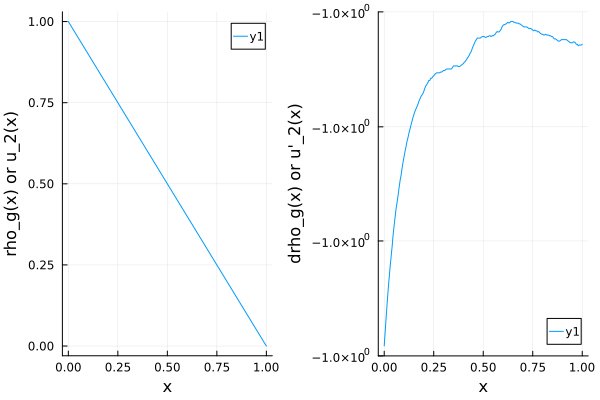

In [72]:
# plot u(x) and du/dx(x)
rhog  = [u[1] for u in sol.u]
drhog = [u[2] for u in sol.u]
p1 = plot(sol.t, rhog, xlabel="x", ylabel = "rho_g(x) or u_2(x)") 
p2 = plot(sol.t, drhog, xlabel="x", ylabel = "drho_g(x) or u'_2(x)") 
plot(p1,p2,layout=(1,2))

### Section 3.2: Transient State: Coupled Reaction-Convection-Diffusion for Solid $u_1$ and Gas $u_2$ Density

In [32]:
# spatial discretization 
N = (10,); Np1 = N[1]+1
m = fdmmesh(N)
A = stiffmat(m)
C = convectionmat(m);

In [35]:
# ODE model functions
function plug_flow_reactor!(du,u,p,t)
    Np1         = length(u) ÷ 2 
    rhos        = @view u[1:Np1]
    rhog        = @view u[Np1+1:end]
    mdot        = 1 .- rhos
    epsilon     = 0.5 
    du[1:Np1]  .= mdot/(1-epsilon)  
    du[Np1+1:end] .= -A*rhog - mdot/epsilon # .= A*rhog - mdot/epsilon  
    du[Np1+1] = 0; du[end] = 0 
end

# set initial conditions 
rhos0 = [.2 for xi in m[1]]
rhog0 = [.3 for xi in m[1]]; rhog0[1] = 0.; rhog0[end] = 0.;  
u0  = [rhos0; rhog0]

# set time interval 
tspan = (0.0,0.1)

# define and solve the problem 
prob = ODEProblem(plug_flow_reactor!,u0,tspan,p)
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8, save_everystep = true);

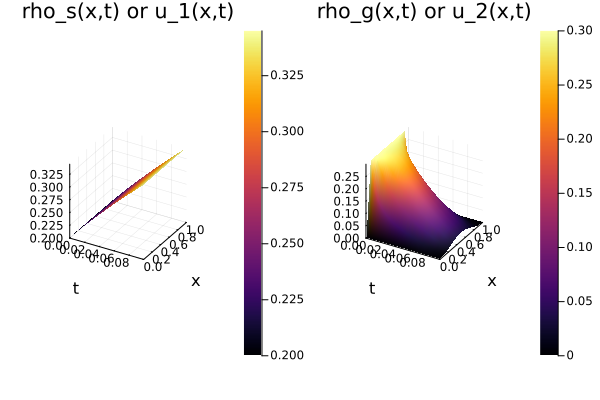

In [36]:
# post-processing 
rhosmat = reduce(hcat,[uti[1:Np1] for uti in sol.u])
rhogmat = reduce(hcat,[uti[Np1+1:end] for uti in sol.u])

p1 = surface(sol.t,m[1],rhosmat,xlabel="t", ylabel="x",title="rho_s(x,t) or u_1(x,t)")
p2 = surface(sol.t,m[1],rhogmat,xlabel="t", ylabel="x",title="rho_g(x,t) or u_2(x,t)")
plot(p1,p2,layout=(1,2))

### Section 4.2: Exercises 
1. Use autodiff=off and provide function thast computes the Jacobian;
2. Explore how the Jacobian used inside the time-stepping procedure is computed;  

## Section 4: More Advanced One-Dimensional Models for the Axial Velocity 

The <b>goal</b> of this section is to arrive at more realistic (non-linear and pressure driven) one-dimensional flow models for the axial velocity in case of filling and emptying the tank. 

The boundary of the tank consists of walls and inlet (in case of filling) and of walls on outlet (in case of emptying) 

<b> Questions: </b>
1. how to apply pressure inlet boundary condition. See [Ansys Fluent Guide](https://www.afs.enea.it/project/neptunius/docs/fluent/html/ug/node239.htm). See also [this CFD online post by Paolo Lampitella](https://www.cfd-online.com/Forums/main/234508-how-properly-set-pressure-inlet-pressure.html)
1. how to use these flow models in the previous (Section 3) models for solid and gas density; 

### Section 4.1: Conservation of momentum 

<b>Problem to solve</b> Given $x \in \Omega = (0,1)$, given the pressure gradient $f(x)$ (we thus avoid solving for the pressure), given the Reynolds number $Re>0$, we intend to solve for the unknown velocity $u(x)$

$$
u(x) \, u'(x) = 1/Re \, u''(x) + f(x) \text{ (conservation of momentum)}
$$

supplied with boundary conditions $u(x=0) = u_{in}$ (left boundary acts as an inlet velocity) and $u(x=0) = 0$ (right boundary condition acts as a wall)

In [16]:
# set source function 
src(x) = 1-x  

# set right-hand side 
# u''(x) + u'(x) = f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    du[1] = u[2]
    du[2] = 5*u[1]*u[2] + src(x)
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    uleft = 1; uright=0; 
    residual[1] = u[1][1] - uleft 
    residual[2] = u[end][1] - uright
end

bc (generic function with 1 method)

In [17]:
# set constants 
p = [1]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

In [18]:
# plot u(x) and du/dx(x)
myv   = [u[1] for u in sol.u]
mydv  = [u[2] for u in sol.u]
rhog  = [u[3] for u in sol.u]
drhog = [u[4] for u in sol.u]
p1 = plot(sol.t, myv, xlabel="x", ylabel = "u(x)") 
p2 = plot(sol.t, mydv, xlabel="x", ylabel = "du/dx(x)") 
p3 = plot(sol.t, rhog, xlabel="x", ylabel = "rho_g(x)") 
p4 = plot(sol.t, drhog, xlabel="x", ylabel = "drho_g(x)") 
plot(p1,p2,p3,p4,layout=(2,2))

LoadError: BoundsError: attempt to access 2-element Vector{Float64} at index [3]

### Section 4.2: Conservation of mass - momentum 

<b>Problem to solve</b> Given $x \in \Omega = (0,1)$ and given the Reynolds number $Re>0$, we intend to solve for the unknown velocity $u(x)$ and pressure $p(x)$ (added stabilization terms in the conservation of mass)

$$
p''(x) = u'(x) \text{ (plus boundary conditions) (conservation of mass)} 
$$

$$
u(x) \, u'(x) = 1/Re \, u''(x) + f(x) = 1/Re \, u''(x) - p'(x) \text{ (plus boundary conditions) (conservation of momentum)}
$$

supplied with the following boundary conditions. This model can again be implemented using a shooting method.

<b>Variational Problem Formulation</b>:

### Section 4.3: Conservation of mass - momentum - energy (to elaborate further) 

1. add transport equation and source term ((de-)compression of gas) for the energy (enthalpy or temperature) to the previous model; 
1. add ideal gas law as equation of state; 

<b>Problem to solve</b> Given $x \in \Omega = (0,1)$, given the Reynolds number $Re>0$, given the Prandtl number $Pr>0$, we intend to solve for the unknown velocity $u(x)$, pressure $p(x)$ and enthalpy (added stabilization terms in the conservation of mass). 

$$
p''(x) = u'(x) \text{ (plus boundary conditions) (conservation of mass)} 
$$

$$
u(x) \, u'(x) = 1/Re \, u''(x) + f(x) = 1/Re \, u''(x) - p'(x) \text{ (plus boundary conditions) (conservation of momentum)}
$$

$$
u(x) \, T'(x) = 1/Pr \, T''(x) + f(x) \text{ (plus boundary conditions) (conservation of energy)} 
$$


### Section 4.4: Exercises 

1. investigate how non-linear term affects the velocity profile in Section 4.1;
2. implement model in Section 4.2;
3. implement model in Section 4.3;

## Section 5: One-Dimensional Model with More Realistic Flow Profile 
1D model combining a convection diffusion equation for the velocity (conservation of momentum) and convection-diffusion equation for the hydrogen gas (hydrogen gas transport). 

In [10]:
# set source function 
src(x) = 1-x  

# set right-hand side 
# u''(x) + u'(x) = f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    v = u[1]; dv = u[2]; rhog = u[3]; drhog = u[4]
    du[1] = dv 
    du[2] = v*dv + src(x)
    du[3] = drhog
    du[4] = v*drhog + src(x)
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    vleft = 1; vright=0; rhogleft = 1; rhogright=0;
    residual[1] = u[1][1] - vleft 
    residual[2] = u[end][1] - vright
    residual[3] = u[1][3] - rhogleft 
    residual[4] = u[end][3] - rhogright
end

bc (generic function with 1 method)

In [11]:
# set constants 
p = [1]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0., 0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

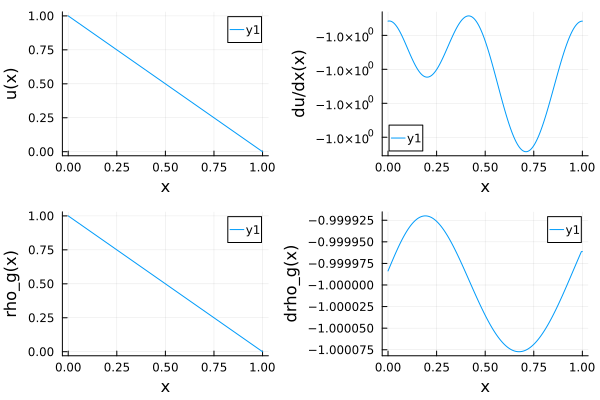

In [12]:
# plot u(x) and du/dx(x)
myv   = [u[1] for u in sol.u]
mydv  = [u[2] for u in sol.u]
rhog  = [u[3] for u in sol.u]
drhog = [u[4] for u in sol.u]
p1 = plot(sol.t, myv, xlabel="x", ylabel = "u(x)") 
p2 = plot(sol.t, mydv, xlabel="x", ylabel = "du/dx(x)") 
p3 = plot(sol.t, rhog, xlabel="x", ylabel = "rho_g(x)") 
p4 = plot(sol.t, drhog, xlabel="x", ylabel = "drho_g(x)") 
plot(p1,p2,p3,p4,layout=(2,2))

## Section 6: Geometry Modeling and Mesh Generation 

See seperate notebook [tankAndNozzle](tankAndNozzle.ipynb). 

### Section 6.1: Exercises 
1. implement a structured mesh for the nozzle-tank geometry;
2. implement a wedge like geometry; 

## Section 7: Potential Flow in 2D Cylindrical Reactor

Solve Laplace Equation for the velocity potential and post-process for the axial ($u_z(r,z)$) and radial velocity ($u_r(r,z)$) components. Solve the Laplace using the mesh file tankAndNozzle.msh as input. Diffusive terms are neglected.    

<b>Coding</b>: see seperate notebook [potential_flow.ipynb](potential_flow.ipynb). 

## Section 8: Stokes Flow (linear pressure/velocity coupling) in 2D Cartesian or 3D Wedge Reactor

Solve linear presssure-velocity coupling using [Stokes flow](https://en.wikipedia.org/wiki/Stokes_flow) model. We thus neglect the non-linear convective terms. We wish to adapt [Ferrite Stokes Flow Tutorial](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/stokes-flow/) to a 2D carthesian or 3D wedge reactor filled with porous material. In the latter case, peridic boundary conditions will have to be employed. The geometry will have no outlet. We thus expect the pressure (or pressure gradient) to increase/decrease as the mass flow rate is increased/decreased.   

<b>Assumptions</b>: No convective term. Possibly add a linear convective term later by an [Oseen](https://en.wikipedia.org/wiki/Oseen_equations) problem formulation. 

<b>Problem Formulation</b>: PDE (conservation of mass and momentum). Neglect convective term. Use [Darcy Law](https://en.wikipedia.org/wiki/Darcy%27s_law) to model the hydraulic conductivy of the metal-oxide framework. We consider the stationary case and thus neglect transient terms (possibly include later). Boundary conditions for velocity: inlet (fix parabolic profile for inlet velocity) and walls (no slip). Use periodic boundary conditions in case of wedge geometry. Boundary conditions for pressure: either fix in single point or apply zero mean value constraint (see e.g. Donea and Huerta).   

<b>Weak or variational formulation</b>: Choice of shape functions for velocity and pressure. 

<b>Spatial discretization</b>: Assembly on interior nodes: three blocks (velocity-velocity, velocity-pressure and pressure-velocity) of the Stokes system. Assembly on the boundary nodes. 

<b>Linear System Solve</b>: solve the Stokes system using LU decomposition (iterative solution methods (Schur complements preconditioned Krylov) of later concern); 

<b>Case Studies</b>: compare absorption and desorption case for both 2D and wegde geometries.

<b>Coding</b>: 
1. notebook [stokes_2d_channel.ipynb](stokes_2d_channel.ipynb): rectangular channel geometry;
2. notebook [stokes_2d_tankNozzle.ipynb](stokes_2d_tankNozzle.ipynb): tank with nozzle geometry; 

### Section 1.8: Exercises 

1. extend to scalar transport after having solved the flow field (in post-processing stage of the flow field). Requires two dof handlers. Firt dof handler for pressure-velocity coupling. Second dof handler for the scalar transport;   
2. extend to linearized Oseen flow, assume the non-linear convective term to be linearized. It suffices to extend the (1,1)-block of the Stokes stiffness matix with a convective term;
3. extend to non-linear Oseen flow, requiring a non-linear solver. Exercise good to in building towards pressure boundary condition;
4. replace tutorial implementatation with implementation using [BlockArrays](https://juliaarrays.github.io/BlockArrays.jl/stable/). This is straightforward as the Navier-Stokes tutorial does this already. Next solve the linear system using a Schur preconditioned GMRES method. Schur complement package in Julia include [GenericSchur](https://ralphas.github.io/GenericSchur.jl/dev/). In this preconditioner the velocity components are solved using an ILU preconditioner. The pressure is solved using an approximate Schur complement. Exercise good to have in building iterative solution method in the transient case; 
5. extend to steady-steady Navier-Stokes flow, thus requiring a non-linear solution approach;
6. extend to scalar transport strongly coupled with the flow field;

## Section 9: Pressure-Inlet Boundary Conditions 

We would like to implement a presssure inlet condition, see e.g. [Fluent Users Guide](https://www.afs.enea.it/project/neptunius/docs/fluent/html/ug/node239.htm) and [this video](https://www.youtube.com/watch?v=Er2j5Kq17as). This requires the development of a iterative solution procedure allowing to solve the non-linearity and the inlet velocity to adapt to the imposed pressure.  

To do: 
1. explain various definitions related to the pressure: static pressure $p_s$ (pressure solved for) and total pressure $p_0$ where
   $p_0 = p_s + \frac{1}{2} \rho \, \vec{v} \cdot \vec{v}$;
3. write down a proper problem definition: linear PDE for the interior nodes, non-linear relationship (non-linear Dirichlet condition) for the boundary nodes;
4. solve the non-linear problem by the method of Picard: guess the pressure (velocity) and solve for velocity (pressure);
5. solve the non-linear problem by the method of Newton. Requires defining right-hand side and the Jacobian;    

## Section 10: Laminar Iso-Thermal Porous Media Flow (non-linear pressure/velocity coupling) in 2D Cartesian or 3D Wedge Reactor   

Solve non-linear presssure-velocity coupling using laminar Navier-Stokes flow model. We thus include non-linear convective terms in the model. We neglect conservation of energy and thus heat effects. We wish to adapt [Ferrite Incompressible Navier-Stokes](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/ns_vs_diffeq/) to a 2D carthesian or 3D wedge reactor filled with porous material. We adapt the boundary condition on the furthest side of the boundary. 

<b>Assumptions</b>: No temperature effects are taken into account. 

<b>Problem Formulation</b>: PDE (conservation of mass and momentum). Transient formulation assumed to reach a steady-state. Boundary conditions for velocity and pressure: as in Stokes case. Initial conditions are set by solves Stokes equations;   

<b>Spatial discretization</b>: The linear part of the equations is treated as in the case of Stokes. The non-linear part is added in weak formulation as a vector to the linear part of the equations. No integration by parts in required to form this vector. This vector is zero in the pressure degrees of freedom. 

<b>Temporal discretization</b>: Using DifferentialEquations.jl. Requires updating the right-hand function and the Jacobian with the non-linear term at each time step. The [Integrator Interface](https://docs.sciml.ai/DiffEqDocs/stable/basics/integrator/#Initialization-and-Stepping) is used to perform time stepping. 
 
<b>Coding</b>: 
1. notebook [navier_stokes_2d_channel.ipynb](navier_stokes_2d_channel.ipynb): rectangular channel geometry;
2. notebook [navier_stokes_2d_tankNozzle.ipynb](navier_stokes_2d_tankNozzle.ipynb): tank with nozzle geometry;

### Section 1.10: Exercises
1. extend the matrix of the linear part of the problem (the function assemble_stokes_matrix) with additional block submatrices to account for an additional scalar transport equation;
2. extend the right-hand function of the non-linear part of the problem with an additional block subvector to account for an additional scalar transport equation. Solve the transient problem using explicit time stepping;
3. extend the Jacobian of the non-linear problem with additional block submatrices. Solve the transient problem using implicit time stepping;

## Section 11: Solid/Gas Density in 2D Cylindrical Reactor with Porous Material  

Extend previous analysis from 1D space (only $x$) to 2D space (both $x$ and $y$). Assume a predefined velocity field for the gas phase velocity. Solve 2 coupled convection-diffusion-reaction equations for $\rho_s(x,y,t)$ and $\rho_g(x,y,t)$. 
1. Adapt [Ferrite Heat Equation Tutorial](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/heat_equation/) (steady state) from from one field to be solved to two fields to be solved for;
1. Similarly, adapt [transient_heat_equation](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/transient_heat_equation/) from from one field to be solved to two fields to be solved for; 

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time: how to perform linear system solve at each time step?  

<b>Coding of Set-up Phase</b>:

## Section 12: Laminar Non-Iso-Thermal Porous Media H2-Gas Flow in Reactor

### Section 1.12: Uni-Directional Pressure-Velocity-Temperature Coupling  

<b>Assumptions</b>: Model the tranport of heat by diffusion and convection with the previously computed flow field. Neglect effect of heat on the flow field. Solve pressure-velocity first. Solve temperature afterwards (either after the final time step or after each step).   

<b>Problem Formulation</b>: PDE + IC + BC. More later. 

<b>Discretization in space</b>: using finite elements. 

<b>Discretization in time in case of linear equation for steady state for temperature</b>: assemble and solve linear system for temperature in steady state. 

<b>Discretization in time in case of transient analysis for temperature</b>: both the explicit and implicit time integration will require the implementation of a right-hand function for the temperature. The implicit time integration will additionally require the assembly and linear system solve with the Jacobian. 

<b>Coding</b>: Extend the tutorial [Ferrite Incompressible Navier-Stokes](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/ns_vs_diffeq/) with temperature field weakly coupled to pressure-velocity field.  

### Section 2.12: Bi-Directional Pressure-Velocity-Temperature Coupling Solved Segregated 
 
<b>Assumptions</b>: Account for heat effects in the flow field (e.g. temperature dependence of the molecular viscosity of the gas). Solve pressure-velocity-temperature in coupled fashion. 

<b>Problem Formulation</b>: identical to above, aside for heat effects in the flow field. 

<b>Discretization in space</b>: using finite elements. How to define the right-hand function for the non-linear contribution? How to define the Jacobian?  

<b>Discretization in time</b>: solve for pressure-velocity-temperature in steady state and in (explicit/implicit) transient manner. The explicit time integration will require the implementation of a right-hand function for the pressure-velocity-temperature. The implicit time integration will additionally require the assembly and linear system solve with the block-coupled Jacobian.

<b>Coding</b>: Further extend the tutorial [Ferrite Incompressible Navier-Stokes](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/ns_vs_diffeq/)  with temperature field strongly coupled to pressure-velocity field.

### Section 3.12: Bi-Directional Pressure-Velocity-Temperature Coupling Solved Coupled 

## Section 13: Hydrogen Ab/Desorption in Reactor 

Ad hydrogen absorption and desorption to the model. 

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

## Section 14: Computational Efficiency - Iterative Methods for Linear Systems 

### Section 1.14: Schur Complement Method for Steady-State Stokes System 

1. Decompose coupled system into blocks. Form (approximate) Schur complement. Run GMRES preconditioned by the Schur complement. Cfr. field-split preconditioner in PETSc library;
2. How to extend to temperature and/or species equations?

### Section 2.14: Schur Complement Method for Steady-State Navier-Stokes System

1. How to embed previous case in non-linear steady-state Navier-Stokes system; 

### Section 3.14: Schur Complement Method for Steady-State Navier-Stokes System

1. How to embed previous case in transient Navier-Stokes system;

## Section 15: Conclusions 

## References 

1. Anoushka's work: [HydrogenProject.ipynb](https://github.com/AnouchkaDESMETTRE/HydrogenProject/blob/main/HydrogenProject.ipynb);
2. Book by Donea and Huerta entitled [Finite Element Methods for Fluid Flow Problems](https://books.google.nl/books?id=S4URqrTtSXoC&printsec=frontcover&redir_esc=y#v=onepage&q&f=false); 